# Wafer Defect Detection

This notebook walks through the process of building and training a model to detect defects on semiconductor wafers.

## 1. Imports

Import all the necessary libraries.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy import interpolate

## 2. Model Definition

Here we define the Convolutional Neural Network (CNN) architecture.

In [ ]:
def build_model(input_shape, num_classes):
    """
    Builds a convolutional neural network (CNN) for image classification.

    Args:
        input_shape (tuple): The shape of the input images (height, width, channels).
        num_classes (int): The number of classes for classification.

    Returns:
        keras.Model: The compiled CNN model.
    """
    model = keras.Sequential([
        # Conv layer 1
        keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=input_shape),
        keras.layers.BatchNormalization(),

        # Block 1
        keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        

        # Block 2
        keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),

        # Flatten features
        keras.layers.Flatten(),

        # Fully connected layers
        keras.layers.Dense(256, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),  # dropout to reduce overfitting

        keras.layers.Dense(128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),

        # Output layer
        keras.layers.Dense(num_classes, activation="softmax")   
    ])

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

## 3. Build and Summarize Model

Now, let's instantiate the model with our specific parameters and print its summary.

In [3]:
INPUT_SHAPE = (25, 27, 1)
NUM_CLASSES = 9

model = build_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

c:\Projects\Wafer-Defect-AI\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 27, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 27, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 27, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,299,625 (4.96 MB)

 Trainable params: 1,298,441 (4.95 MB)

 Non-trainable params: 1,184 (4.62 KB)

## 4. Load Data

Load the wafer map data from the pickle file.

In [4]:
# The notebook is in the 'src' directory, so we go up one level to find the 'data' directory.
file_path = os.path.join('..', 'data', 'LSWMD.pkl')
df = pd.read_pickle(file_path)

# Display the first few rows to verify it loaded correctly
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


## 5. Preprocessing and Cleaning

Prepare the data for the model. This includes dropping unnecessary columns and converting labels into a numerical format.

Remove any unwanted columns

In [5]:
# The 'waferIndex' is not needed for classification
df = df.drop(['waferIndex'], axis = 1)
df = df.drop(['lotName'], axis = 1)

In [11]:
df.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)

# Create new columns with numerical representations of the labels
df['failureNum'] = df.failureType
df['trainTestNum'] = df.trainTestLabel
mapping_type = {'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest = {'Training':0, 'Test':1}
df = df.replace({'failureNum': mapping_type, 'trainTestNum': mapping_traintest})

# Unlabeled = those with empty ndarray
df_unlabeled = df[df["failureNum"].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0)]

# Keep only labeled (failureNum is an int)
df_labeled = df[df["failureNum"].apply(lambda x: isinstance(x, int))]

print("Unlabeled count:", len(df_unlabeled))
print("Labeled count:", len(df_labeled))


Unlabeled count: 638507
Labeled count: 172950


In [12]:
# Split 80/20 
df_train, df_test = train_test_split(
    df_labeled,
    test_size=0.2,
    stratify=df_labeled["failureNum"],
    random_state=42
)

# Check the data types and non-null counts
print(df_train['failureType'].value_counts())
print(df_test['failureType'].value_counts())

failureType
[[none]]         117945
[[Edge-Ring]]      7744
[[Edge-Loc]]       4151
[[Center]]         3435
[[Loc]]            2875
[[Scratch]]         954
[[Random]]          693
[[Donut]]           444
[[Near-full]]       119
Name: count, dtype: int64
failureType
[[none]]         29486
[[Edge-Ring]]     1936
[[Edge-Loc]]      1038
[[Center]]         859
[[Loc]]            718
[[Scratch]]        239
[[Random]]         173
[[Donut]]          111
[[Near-full]]       30
Name: count, dtype: int64


## 6. Data Exploration and Visualization

Let's visualize some of the wafer maps to get a feel for the data.

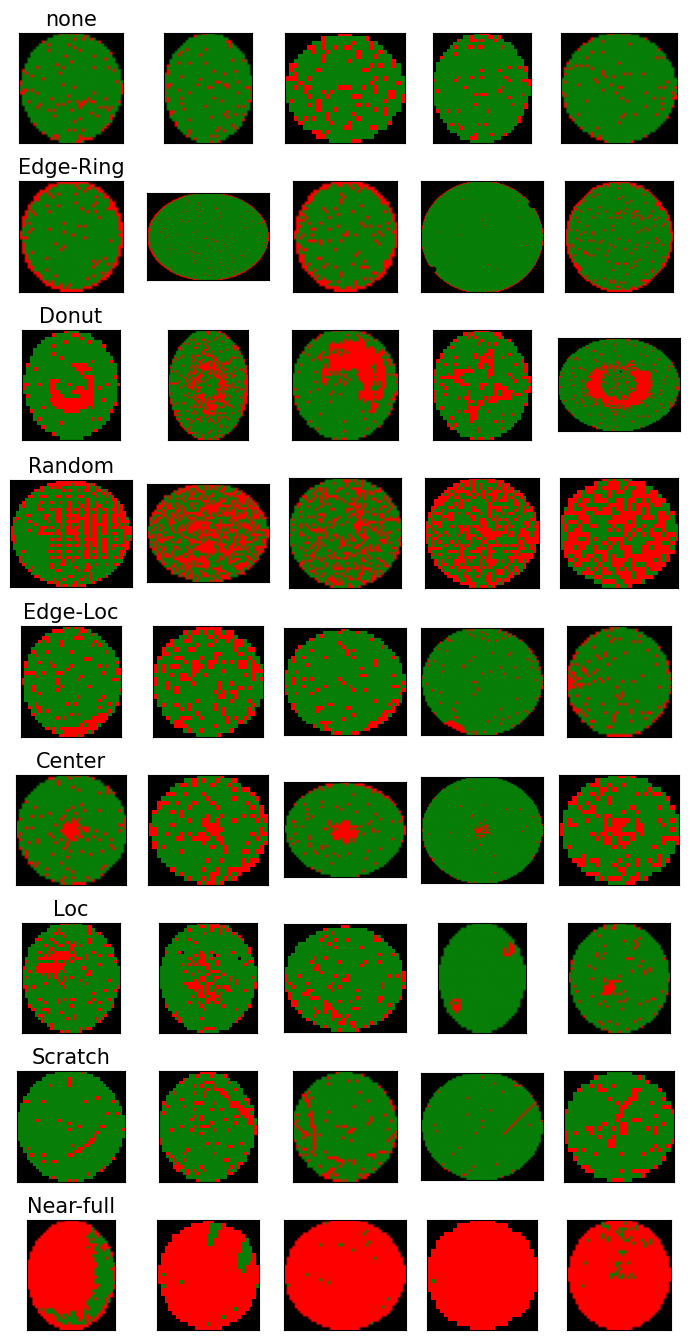

In [14]:
# Define a custom colormap
# 0: background (black)
# 1: good die (green)
# 2: defective die (red)
cmap = ListedColormap(['black', "#077e07", 'red'])

num_to_show = 5

unique_types = df_train["failureNum"].unique()   # includes 'none'

fig, axes = plt.subplots(nrows=len(unique_types), ncols=num_to_show, figsize=(7,1.5*len(unique_types)))

for row_idx, type in enumerate(unique_types):
    # sample 5 wafers of this type
    subset = df_train[df_train["failureNum"] == type].sample(n=num_to_show, random_state=69)

    for col_idx, wafer in enumerate(subset["waferMap"]):
        ax = axes[row_idx, col_idx]
        ax.imshow(wafer, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])

        if col_idx == 0:  # only label once per row
            label = subset.failureType.iloc[0][0][0]  # first element of the first row
            ax.set_title(label, fontsize=15, pad=5) 
plt.tight_layout()
plt.show()

## 7. Data Augmentation

After looking at the training data, there is a huge imbalance in failure types (68% of the data is just 'none'). This is where data augmentation comes into play.

Data augmentation is a crucial step to handle the imbalanced dataset. We can create new training samples from the minority classes by applying transformations like flipping and rotating.

Below are some functions to augment the wafer maps. These can be used to oversample the minority classes in the `df_train` DataFrame to create a more balanced dataset for training the model.

In [19]:
from skimage.transform import AffineTransform, warp

# --- Targeted augmentation functions ---

def augment_positional(wafer_map):
    """Augmentation for positional patterns (Center, Edge-Loc, Edge-Ring, Loc)."""
    augmented = []
    augmented.append(np.fliplr(wafer_map))
    augmented.append(np.flipud(wafer_map))
    transform = AffineTransform(translation=(2, 2))
    augmented.append(warp(wafer_map, transform, mode="edge"))
    transform = AffineTransform(translation=(-2, -2))
    augmented.append(warp(wafer_map, transform, mode="edge"))
    return augmented

def augment_scratch(wafer_map):
    """Augmentation for Scratch defects (preserve line-like structure)."""
    augmented = []
    augmented.append(np.rot90(wafer_map, 1))
    augmented.append(np.rot90(wafer_map, 2))
    return augmented

def augment_rare(wafer_map):
    """Augmentation for rare classes (Donut, Near-full, Random)."""
    augmented = []
    for k in [1, 2, 3]:
        augmented.append(np.rot90(wafer_map, k))
    noise = wafer_map + np.random.choice([0, 1, 2], size=wafer_map.shape, p=[0.9, 0.09, 0.01])
    augmented.append(np.clip(noise, 0, 2))
    return augmented

# --- Apply augmentation to dataset ---

print("Original training data distribution:")
print(df_train['failureType'].value_counts())

# 1. Downsample "none" type wafers 
df_none = df_train[df_train["failureNum"] == 8].sample(8000, random_state=42)

# Get all other wafer types
df_other_types = df_train[df_train["failureNum"] != 8]

augmented_list = []

# Loop over unique classes in the non-'none' dataframe
for failure_num in df_other_types['failureNum'].unique():
    class_df = df_other_types[df_other_types['failureNum'] == failure_num]
    num_samples = len(class_df)
    
    # Decide which augmenter to use
    if failure_num in [0, 2, 3, 4]:   # Center, Edge-Loc, Edge-Ring, Loc
        augmenter = augment_positional
    elif failure_num == 6:            # Scratch
        augmenter = augment_scratch
    elif failure_num in [1, 5, 7]:    # Donut, Random, Near-full
        augmenter = augment_rare
    else:
        augmenter = None
    
    # Only augment if we have fewer than 2000 samples
    if num_samples < 2000 and augmenter is not None:
        num_to_generate = 2000 - num_samples
        wafers_to_augment = class_df['waferMap'].values
        generated_count = 0
        
        while generated_count < num_to_generate:
            wafer_to_augment = wafers_to_augment[np.random.randint(0, num_samples)]
            augmented_wafers = augmenter(wafer_to_augment)
            
            for wafer in augmented_wafers:
                if generated_count < num_to_generate:
                    new_row = class_df.iloc[0].copy()
                    new_row['waferMap'] = wafer
                    augmented_list.append(new_row)
                    generated_count += 1

# Create a new dataframe with augmented samples
df_augmented = pd.DataFrame(augmented_list)

# Merge the downsampled 'none' wafers, the original other types, and the new augmented wafers
df_train_augmented = pd.concat([df_none, df_other_types, df_augmented], ignore_index=True)

print("Augmented training data distribution:")
print(df_train_augmented['failureType'].value_counts())

Original training data distribution:
failureType
[[none]]         117945
[[Edge-Ring]]      7744
[[Edge-Loc]]       4151
[[Center]]         3435
[[Loc]]            2875
[[Scratch]]         954
[[Random]]          693
[[Donut]]           444
[[Near-full]]       119
Name: count, dtype: int64
Augmented training data distribution:
failureType
[[none]]         8000
[[Edge-Ring]]    7744
[[Edge-Loc]]     4151
[[Center]]       3435
[[Loc]]          2875
[[Random]]       2000
[[Donut]]        2000
[[Scratch]]      2000
[[Near-full]]    2000
Name: count, dtype: int64


Visualization of the different sizes of the wafermaps. This will help decide what the input size of the data should be changed to in order to train

--- Frequency of Unique Wafer Map Sizes ---
     height  width  count
0        25     27   3500
1        26     26   1799
2        38     36   1722
3        39     37   1483
4        30     34   1268
..      ...    ...    ...
375      42     39      1
376      55     52      1
377      54     54      1
378      55     68      1
379      41     30      1

[412 rows x 3 columns]


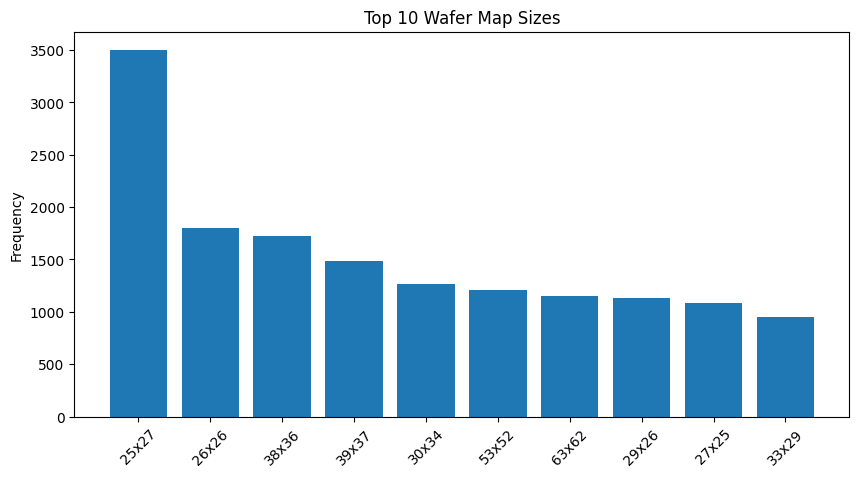

In [20]:
# Get the dimensions of each wafer map
dims = df_train_augmented['waferMap'].apply(lambda x: x.shape)

# Convert to a DataFrame of (height, width)
dims_df = pd.DataFrame(dims.tolist(), columns=['height', 'width'])

# Count frequency of each unique size
size_counts = dims_df.value_counts().reset_index(name='count')
size_counts = size_counts.sort_values(by='count', ascending=False)

print("--- Frequency of Unique Wafer Map Sizes ---")
print(size_counts)

# Optional: plot the top 10 most common sizes
top_sizes = size_counts.head(10)
plt.figure(figsize=(10,5))
plt.bar([f"{h}x{w}" for h, w in zip(top_sizes['height'], top_sizes['width'])],
        top_sizes['count'])
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.title("Top 10 Wafer Map Sizes")
plt.show()


## 8. Data Preparation for the Model

Now we will prepare the data for training. This involves:
1.  Separating features (X) and labels (y).
2.  Reshaping and normalizing the wafer map images.
3.  Splitting the augmented training data into training and validation sets.

Displaying 'before' and 'after' for wafers with different original sizes.


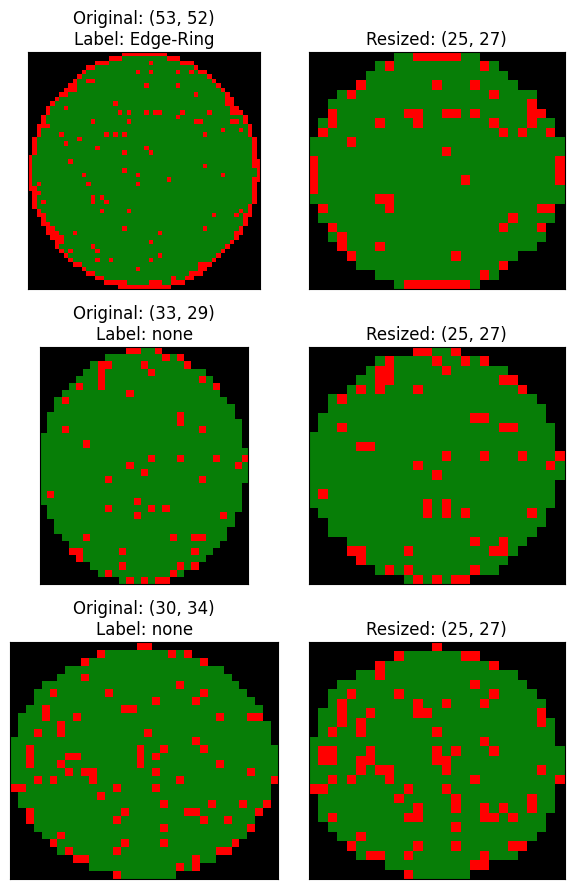

In [31]:
# --- Code to Visualize Wafer Resizing ---

# Define the target size again just in case
TARGET_SIZE = (25, 27)
cmap = ListedColormap(['black', "#077e07", 'red'])

# Find some wafers that are NOT the target size to use as examples
non_target_size_df = df_train_augmented[df_train_augmented['waferMap'].apply(lambda x: x.shape != TARGET_SIZE)]

if non_target_size_df.empty:
    print(f"No wafers found with dimensions other than {TARGET_SIZE} to display.")
else:
    # Pick a few random examples from this subset
    num_examples = 3
    # Ensure we don't try to sample more examples than exist
    sample_size = min(num_examples, len(non_target_size_df))
    examples = non_target_size_df.sample(sample_size, random_state=42)

    fig, axes = plt.subplots(nrows=sample_size, ncols=2, figsize=(6, 3 * sample_size))

    # Handle the case where sample_size is 1, to prevent indexing errors
    if sample_size == 1:
        axes = np.array([axes])

    print("Displaying 'before' and 'after' for wafers with different original sizes.")

    for i in range(sample_size):
        # Get the original wafer map and its properties
        original_wafer = examples['waferMap'].iloc[i]
        original_shape = original_wafer.shape

        # Safely access the failure type label
        try:
            label = examples['failureType'].iloc[i][0][0]
        except (IndexError, TypeError):
            label = "Unknown"

        # Resize the wafer just like in the preprocessing function
        resized_wafer = resize(original_wafer, TARGET_SIZE, anti_aliasing=True)

        # Plot the original wafer
        ax1 = axes[i, 0]
        ax1.imshow(original_wafer, cmap=cmap)
        ax1.set_title(f"Original: {original_shape}\nLabel: {label}")
        ax1.set_xticks([])
        ax1.set_yticks([])

        # Plot the resized wafer
        ax2 = axes[i, 1]
        ax2.imshow(resized_wafer, cmap=cmap)
        ax2.set_title(f"Resized: {TARGET_SIZE}")
        ax2.set_xticks([])
        ax2.set_yticks([])

    plt.tight_layout()
    plt.show()

In [21]:
# All wafer maps need to be resized to a single size for the CNN input
TARGET_SIZE = (25, 27)

def preprocess_wafers(df, target_size):
    """Resizes and preprocesses a dataframe of wafer maps."""
    resized_maps = []
    for i in range(len(df)):
        wafer = df['waferMap'].iloc[i]
        # Resize the image and normalize it to the range [0, 1]
        resized_wafer = resize(wafer, target_size, anti_aliasing=True)
        resized_maps.append(resized_wafer)
    
    # Convert the list of resized maps to a 4D numpy array (samples, height, width, channels)
    X = np.stack(resized_maps).astype('float32')
    X = X.reshape(-1, target_size[0], target_size[1], 1)
    
    y = df['failureNum'].astype("int32").values
    return X, y

# Change the size of the wafers to 25x27
X, y = preprocess_wafers(df_train_augmented, TARGET_SIZE)
X_test, y_test = preprocess_wafers(df_test, TARGET_SIZE)


# Split the augmented training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training data shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Training data shape: (27364, 25, 27, 1)
Training labels shape: (27364,)
Validation data shape: (6841, 25, 27, 1)
Validation labels shape: (6841,)
Test data shape: (34590, 25, 27, 1)
Test labels shape: (34590,)


## 9. Model Training

Now we can train the model using our prepared training and validation data.

In [27]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
from scipy import stats
from sklearn.utils import class_weight

# Define the Learning Rate Schedule Function
def lr_step_decay(epoch, lr):
     """
     Decays the learning rate in steps.
     Starts at 0.001, drops to 0.0005 after 5 epochs, then 0.00025 after 10 epochs.
     """
     initial_lr = 0.001
     drop_rate = 0.5  # Drop the LR by half
     epochs_drop = 5  # Drop it every 5 epochs

     new_lr = initial_lr * (drop_rate ** np.floor((1 + epoch) / epochs_drop))
     return new_lr

# Decreases learning rate dynamically
lr_scheduler = LearningRateScheduler(lr_step_decay, verbose=1)

# Calculate class weights to handle data imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

EPOCHS = 10
BATCH_SIZE = 32

# To avoid overtraining, we use an early stop if validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - accuracy: 0.8252 - loss: 0.5199 - val_accuracy: 0.8360 - val_loss: 0.4375
Epoch 2/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.8388 - loss: 0.4642 - val_accuracy: 0.8661 - val_loss: 0.3570
Epoch 3/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - accuracy: 0.8665 - loss: 0.3855 - val_accuracy: 0.8262 - val_loss: 0.5503
Epoch 4/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 101s 118ms/step - accuracy: 0.8746 - loss: 0.3555 - val_accuracy: 0.8661 - val_loss: 0.3549
Epoch 5/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 68s 80ms/step - accuracy: 0.8919 - loss: 0.3099 - val_accuracy: 0.6408 - val_loss: 1.5938
Epoch 6/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.8964 - loss: 0.2912 - val_accuracy: 0.8639 - val_loss: 0.3912
Epoch 7/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9076 - loss: 0.2648 - val_accuracy: 0.8366 - val_loss: 0.5667


## 10. Visualize Training History

Plotting the model's accuracy and loss over epochs helps us understand the training process.

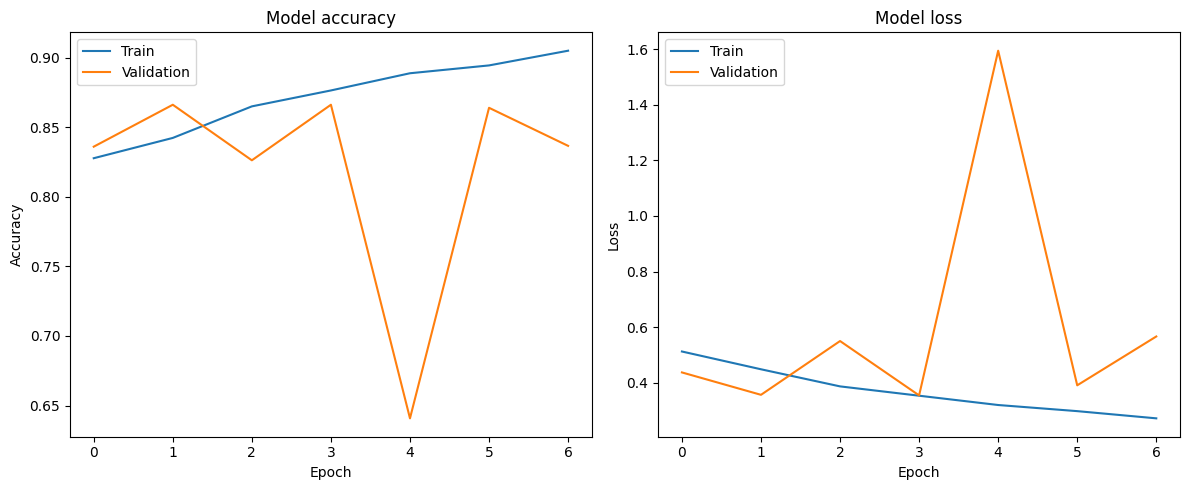

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## 11. Evaluate the Model

Let's evaluate the final model on the test set to see how well it generalizes to new, unseen data.

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3897
Test Accuracy: 0.8717


### 11.2 Confusion Matrix

C:\Users\augus\AppData\Local\Temp\ipykernel_51936\767923065.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby("failureNum", group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)


Index(['waferMap', 'dieSize', 'trainTestLabel', 'failureType', 'failureNum',
       'trainTestNum'],
      dtype='object')
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

      Center       0.93      0.97      0.95       500
       Donut       0.88      0.90      0.89       111
    Edge-Loc       0.87      0.76      0.81       500
   Edge-Ring       0.98      0.92      0.95       500
         Loc       0.83      0.72      0.77       500
      Random       0.80      0.95      0.87       173
     Scratch       0.63      0.75      0.68       239
   Near-full       0.83      1.00      0.91        30
        none       0.79      0.88      0.83       500

    accuracy                           0.85      3053
   macro avg       0.84      0.87      0.85      3053
weighted avg       0.86      0.85      0.85      3053



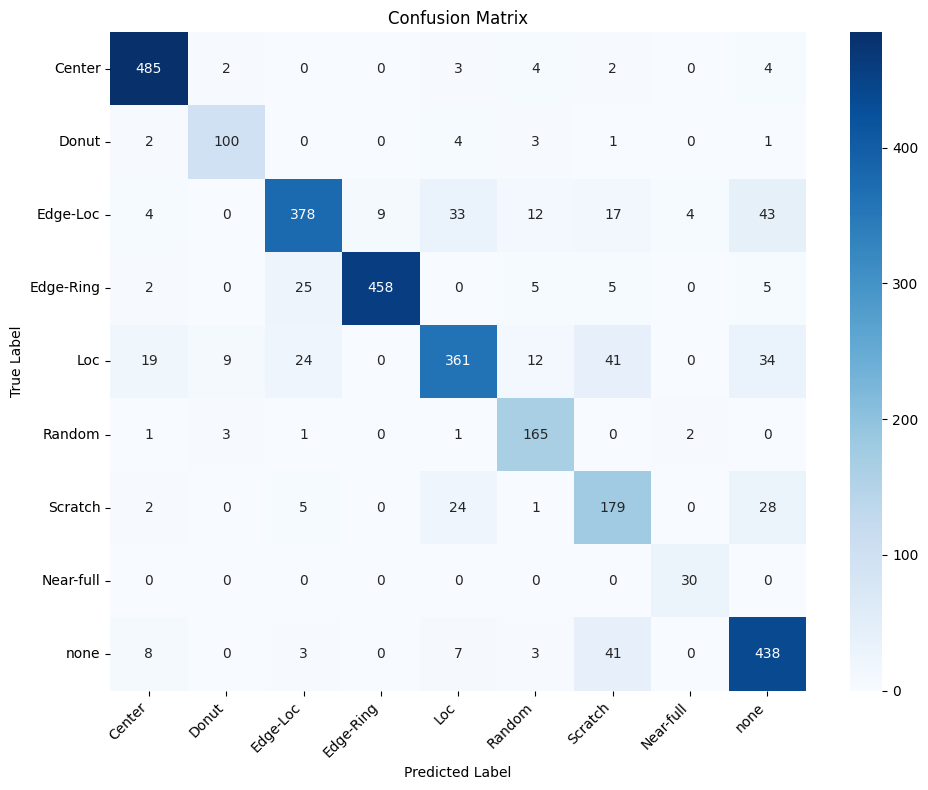

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# To get the corresponding labels for each failure number
labels = [key for key, value in sorted(mapping_type.items(), key=lambda item: item[1])]

# Balancing the test data since most of it is just "None"
# Getting a max of 500 per class
df_test_balanced = df_test.groupby("failureNum", group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
print(df_test.columns)

X_test_balanced, y_test_balanced = preprocess_wafers(df_test_balanced, TARGET_SIZE)


# Predict on test set
y_pred = model.predict(X_test_balanced).argmax(axis=1)

# Print per-class precision/recall/F1
print(classification_report(y_test_balanced, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_test_balanced, y_pred)

plt.figure(figsize=(10, 8)) # Adjusted size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to make room for label
plt.show()

In [26]:
# See the first 50 predictions vs labels
print("Predicted:", y_pred[:100])
print("True:", y_test_balanced[:100])

Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 8 0 4 0 0 5 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
True: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 12. Save the Trained Model

Finally, we'll save the trained model to a file so it can be loaded and used later without retraining.

In [ ]:
# model_dir = os.path.join('..', 'models')
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# model_path = os.path.join(model_dir, 'wafer_defect_model.h5')
# model.save(model_path)
# print(f'Model saved to {model_path}')